### Generate Individual vDAC Components

In [1]:
import hdl21 as h
from vdac import *
import sky130_hdl21 as s
from sitepdks import *

import vlsirtools.spice as vsp

h.elaborate(gen_vDAC())

Module(name=gen_vDAC(npar=2 ncells=6))

### Test Dynamic Bus Signal

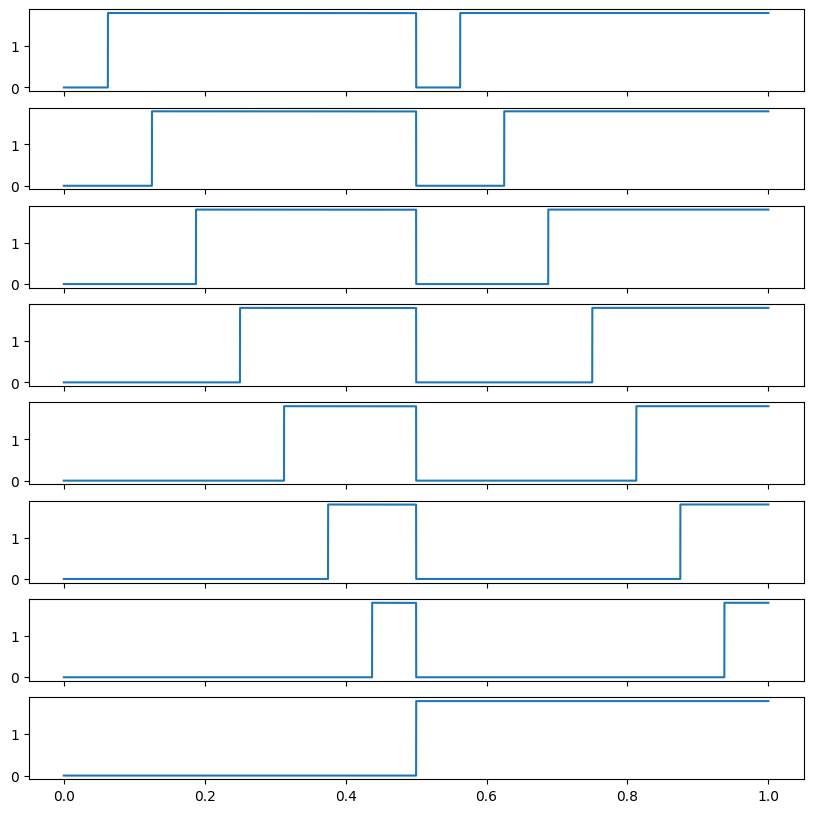

In [6]:
from vsources import *
import hdl21.prefix as hp
import vlsirtools.spice as vsp

@h.sim.sim
class dbsSim:

    @h.module
    class Tb:

        VSS = h.Port()
        vout = h.Signal(width=8)

        dbs = dynamic_step_signal(width=8,time=1*hp.UNIT)(vss=VSS,vout=vout)

    # Simulation Controls
    tran = h.sim.Tran(tstop=1*hp.UNIT, tstep=1*hp.MICRO)

opts = vsp.SimOptions(
    simulator=vsp.SupportedSimulators.NGSPICE,
    fmt=vsp.ResultFormat.SIM_DATA,
    rundir="./scratch",
)

rv = dbsSim.run(opts)
op = rv[vsp.sim_data.AnalysisType.TRAN]

import matplotlib.pyplot as plt

fig, axs = plt.subplots(8,1,figsize=(10,10),sharex=True)

for i in range(8):
    axs[i].plot(op.data["time"],op.data[f"v(xtop.vout_{i})"])

### vDAC Fuzzing

We want to cycle through all of the $2^8$ digital signals that can be input and see how Pretl's "ana-ligital" vDAC holds up. 

In [3]:
@h.sim.sim
class vDAC_Fuzzing:

    @h.module
    class Tb:
        VSS = h.Port()
        out = h.Signal()
    
        vdc = h.Vdc(dc=1.8)(n=VSS)
        vdac = gen_vDAC(ncells=8,npar=1)(vout=out, enable=vdc.p, VSS=VSS, VDD=vdc.p)
        vsources = dynamic_step_signal(width=8,time=1*hp.UNIT)(vss=VSS,vout=vdac.inp_bus)

    # Simulation Controls
    tran = h.sim.Tran(tstop=1*hp.UNIT, tstep=1*hp.MILLI)
    inc_base = s.install.include(h.pdk.Corner.TYP)
    inc_cells = h.sim.Include(
            sky130.install.pdk_path /
            "libs.ref/sky130_fd_sc_hd/spice/sky130_fd_sc_hd.spice"
    )

opts = vsp.SimOptions(
    simulator=vsp.SupportedSimulators.NGSPICE,
    fmt=vsp.ResultFormat.SIM_DATA,
    rundir="./scratch",
)

rv = vDAC_Fuzzing.run(opts)
op = rv[vsp.sim_data.AnalysisType.TRAN]

op.data.keys()

dict_keys(['time', 'v(xtop.vdc_p)', 'v(xtop.vdac_inp_bus_0)', 'v(xtop.xvdac.xparacell0.xcell0.npu_pd_y)', 'v(xtop.xvdac.xparacell0.xcell0.xxor.a_35_297#)', 'v(xtop.vdac_inp_bus_7)', 'v(xtop.xvdac.xparacell0.xcell0.xor_x)', 'v(xtop.xvdac.xparacell0.xcell0.xxor.a_285_297#)', 'v(xtop.xvdac.xparacell0.xcell0.xxor.a_117_297#)', 'v(xtop.xvdac.xparacell0.xcell0.xxor.a_285_47#)', 'v(xtop.xvdac.xparacell0.xcell0.xen_vref.a_59_75#)', 'v(xtop.xvdac.xparacell0.xcell0.en_vref_x)', 'v(xtop.xvdac.xparacell0.xcell0.xen_vref.a_145_75#)', 'v(xtop.xvdac.xparacell0.xcell0.ixor_y)', 'v(xtop.xvdac.xparacell0.xcell0.xen_pupd.a_59_75#)', 'v(xtop.xvdac.xparacell0.xcell0.en_pupd_x)', 'v(xtop.xvdac.xparacell0.xcell0.xen_pupd.a_145_75#)', 'v(xtop.xvdac.xparacell0.xcell0.xcell_1.a_276_297#)', 'v(xtop.out)', 'v(xtop.xvdac.xparacell0.xcell0.xcell_1.a_204_47#)', 'v(xtop.xvdac.xparacell0.xcell0.xcell_1.a_27_47#)', 'v(xtop.xvdac.xparacell0.xcell0.xcell_2.a_276_297#)', 'v(xtop.xvdac.xparacell0.xcell0.xcell_2.a_204_47#)'

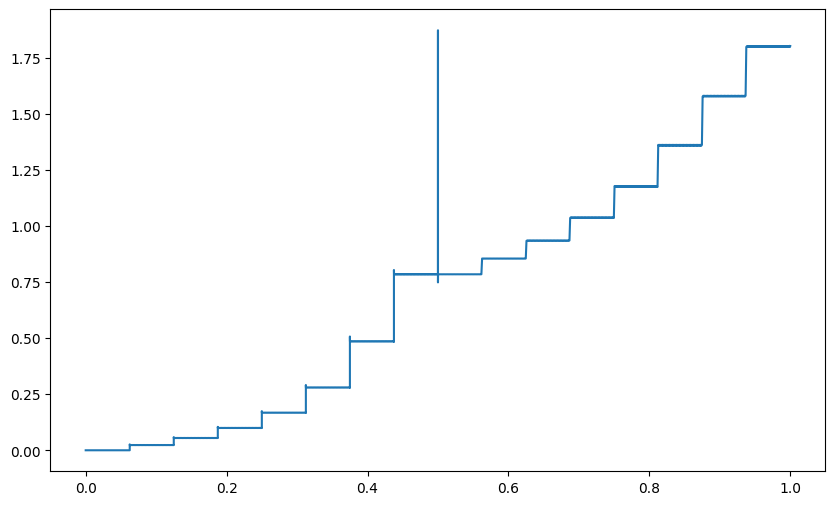

In [4]:
fig,ax = plt.subplots(figsize=(10,6))
ax.plot(op.data['time'],op.data['v(xtop.out)'])

In [4]:
import hdl21 as h
import hdl21.prefix as hp
import sky130_hdl21 as sky130
from sitepdks import *

import vlsirtools.spice as vsp

from ro import *
from vsources import *
from vdac import *

@h.sim.sim
class TransientSim:

    @h.module
    class Tb:

        # Params
        w_param = 8

        # Ports and Signals
        VSS = h.Port()
        VDD,OUT,ctrl = 3*h.Signal()
        inp = h.Signal(width=w_param)

        # Components
        vdd = h.PulseVoltageSource(
            delay=0,
            v1=0,
            v2=1.8,
            period=0,
            rise=10*hp.NANO,
            fall=1*hp.NANO,
            width=1
        )(p=VDD,n=VSS)

        signal_in = dynamic_step_signal(width=w_param, time=200*hp.NANO)(vout=inp, vss=VSS)
        vdac = gen_vDAC(ncells=w_param)(inp_bus=signal_in.vout, enable=VDD, VSS=VSS, VDD=VDD)

        vcro = gen_VCRO(stages=51)(VSS=VSS,
                                   VDD=VDD,
                                   CTRL=vdac.vout,
                                   OUT=OUT,
                                   ENABLE=VDD)
        
    # Simulation Controls
    tran = h.sim.Tran(tstop=200*hp.NANO, tstep=1*hp.PICO)
    inc_base = sky130.install.include(h.pdk.Corner.TYP)
    inc_cells = h.sim.Include(
            sky130.install.pdk_path /
            "libs.ref/sky130_fd_sc_hd/spice/sky130_fd_sc_hd.spice"
    )

opts = vsp.SimOptions(
        simulator=vsp.SupportedSimulators.NGSPICE,
        fmt=vsp.ResultFormat.SIM_DATA,
        rundir="./scratch",
    )

rv = TransientSim.run(opts)
op = rv[vsp.sim_data.AnalysisType.TRAN]

In [7]:
op.data.keys()

dict_keys(['time', 'v(xtop.vdd)', 'v(xtop.inp_0)', 'v(xtop.inp_1)', 'v(xtop.inp_2)', 'v(xtop.inp_3)', 'v(xtop.inp_4)', 'v(xtop.inp_5)', 'v(xtop.inp_6)', 'v(xtop.inp_7)', 'v(xtop.xvdac.xparacell0.xcell0.npu_pd_y)', 'v(xtop.xvdac.xparacell0.xcell0.xxor.a_35_297#)', 'v(xtop.xvdac.xparacell0.xcell0.xor_x)', 'v(xtop.xvdac.xparacell0.xcell0.xxor.a_285_297#)', 'v(xtop.xvdac.xparacell0.xcell0.xxor.a_117_297#)', 'v(xtop.xvdac.xparacell0.xcell0.xxor.a_285_47#)', 'v(xtop.xvdac.xparacell0.xcell0.xen_vref.a_59_75#)', 'v(xtop.xvdac.xparacell0.xcell0.en_vref_x)', 'v(xtop.xvdac.xparacell0.xcell0.xen_vref.a_145_75#)', 'v(xtop.xvdac.xparacell0.xcell0.ixor_y)', 'v(xtop.xvdac.xparacell0.xcell0.xen_pupd.a_59_75#)', 'v(xtop.xvdac.xparacell0.xcell0.en_pupd_x)', 'v(xtop.xvdac.xparacell0.xcell0.xen_pupd.a_145_75#)', 'v(xtop.xvdac.xparacell0.xcell0.xcell_1.a_276_297#)', 'v(xtop.vdac_vout)', 'v(xtop.xvdac.xparacell0.xcell0.xcell_1.a_204_47#)', 'v(xtop.xvdac.xparacell0.xcell0.xcell_1.a_27_47#)', 'v(xtop.xvdac.xpa

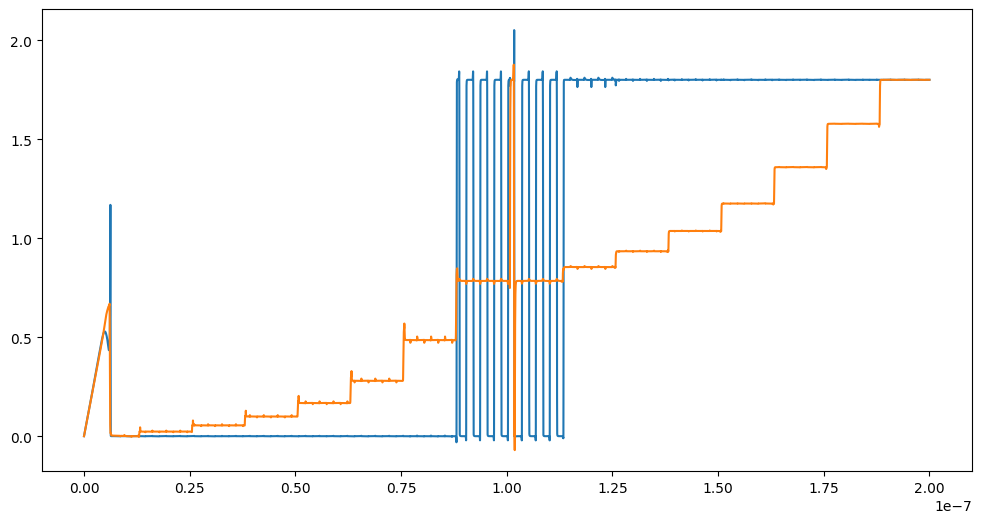

In [8]:
import matplotlib.pyplot as plt

fig,axs = plt.subplots(1,1,figsize=(12,6))
axs.plot(op.data['time'],op.data['v(xtop.out)'])
axs.plot(op.data['time'],op.data['v(xtop.vdac_vout)'])